In [2]:
# general use
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from my_plot import PrettyPlot
PrettyPlot(plt)

# machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline;

# Data Pre-processing and Feature Engineering

In [118]:
train = pd.read_csv('train.csv', na_values=-1)
holdout = pd.read_csv('test.csv', na_values=-1)

train_ids = train.id
holdout_ids = holdout.id

del train['id']
del holdout['id']

In [119]:
new_col_train = [col.replace('ps_', '') for col in train.columns]
new_col_holdout = [col.replace('ps_', '') for col in holdout.columns]
train.columns = new_col_train
holdout.columns = new_col_holdout

In [120]:
print('train size:', train.shape)
print('holdout size:', holdout.shape)
train.dtypes
train.head()

train size: (595212, 58)
holdout size: (892816, 57)


target           int64
ind_01           int64
ind_02_cat     float64
ind_03           int64
ind_04_cat     float64
ind_05_cat     float64
ind_06_bin       int64
ind_07_bin       int64
ind_08_bin       int64
ind_09_bin       int64
ind_10_bin       int64
ind_11_bin       int64
ind_12_bin       int64
ind_13_bin       int64
ind_14           int64
ind_15           int64
ind_16_bin       int64
ind_17_bin       int64
ind_18_bin       int64
reg_01         float64
reg_02         float64
reg_03         float64
car_01_cat     float64
car_02_cat     float64
car_03_cat     float64
car_04_cat       int64
car_05_cat     float64
car_06_cat       int64
car_07_cat     float64
car_08_cat       int64
car_09_cat     float64
car_10_cat       int64
car_11_cat       int64
car_11         float64
car_12         float64
car_13         float64
car_14         float64
car_15         float64
calc_01        float64
calc_02        float64
calc_03        float64
calc_04          int64
calc_05          int64
calc_06    

,target,ind_01,ind_02_cat,ind_03,ind_04_cat,ind_05_cat,ind_06_bin,ind_07_bin,ind_08_bin,ind_09_bin,...,calc_11,calc_12,calc_13,calc_14,calc_15_bin,calc_16_bin,calc_17_bin,calc_18_bin,calc_19_bin,calc_20_bin
0,0,2,2.0,5,1.0,0.0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,0,1,1.0,7,0.0,0.0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,0,5,4.0,9,1.0,0.0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,0,0,1.0,2,0.0,0.0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,0,2.0,0,1.0,0.0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


### Visualization of Target and Features

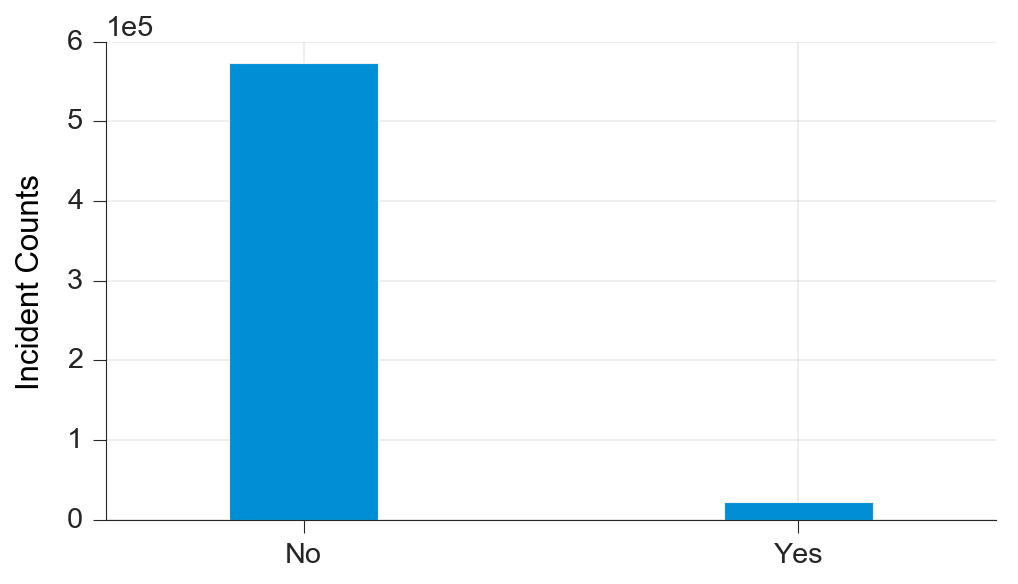

In [7]:
ax = train.target.value_counts().plot.bar(width=0.3)
ax.set_ylabel('Incident Counts')
plt.xticks(range(0,2), ['No', 'Yes'], rotation=360);

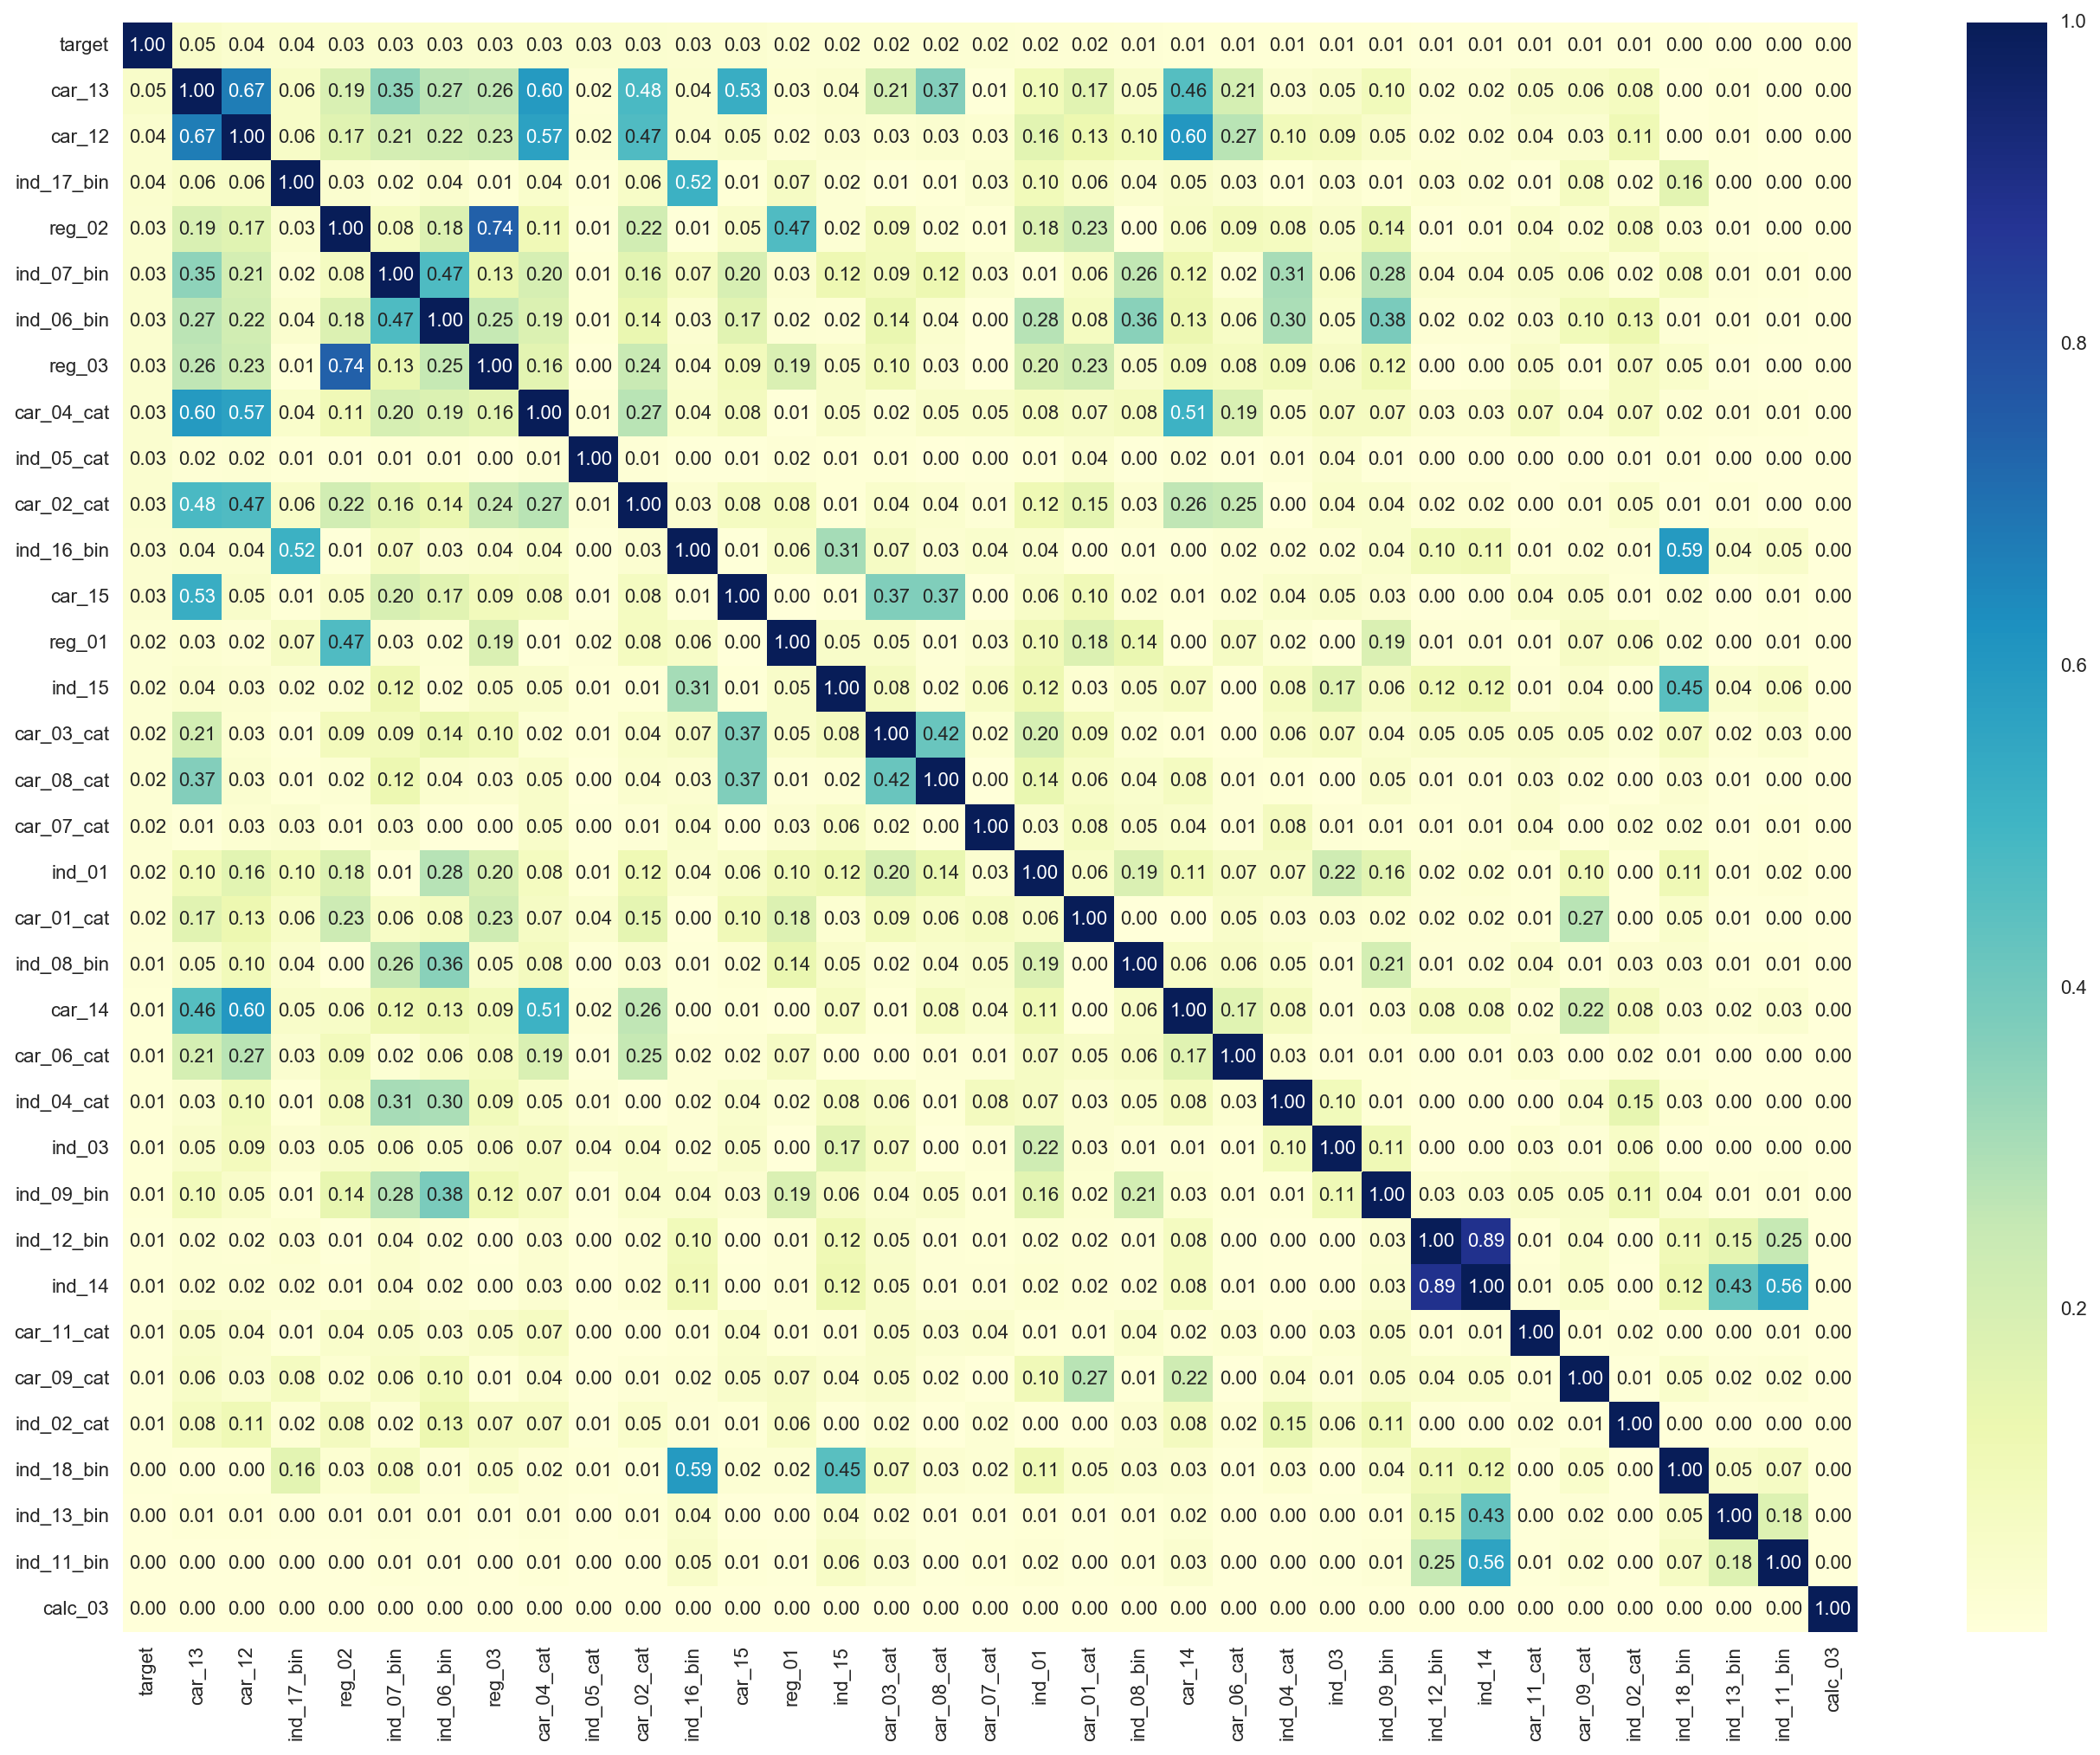

In [8]:
plt.figure(figsize=(18,14))
k = 35
corrmat = abs(train.corr())
cols_large = corrmat.nlargest(k, 'target').index
hm_large = corrmat.nlargest(k,'target')[cols_large]
sns.set(font_scale=1);
sns.heatmap(hm_large, cbar=True, cmap="YlGnBu", annot=True, 
            square=False, fmt='.2f', annot_kws={'size': 10});
PrettyPlot(plt);

In [121]:
train = train[cols_large]
holdout = holdout[cols_large[1:]]

### One-hot Encoding Categorical Variables

In [122]:
cat_columns = [col for col in train.columns if col.endswith(('cat', 'cut'))]

for col in cat_columns:
    train[col] = train[col].astype('category')

In [123]:
def create_dummies(df):
    cat_columns = [col for col in df.columns if col.endswith(('cat', 'cut'))]

    for col in cat_columns:
        df[col] = df[col].astype('category')
        
    dummies = pd.get_dummies(df[cat_columns])
    df = pd.concat([df, dummies], axis=1).drop(cat_columns, axis=1)
    
    return df

In [124]:
train = create_dummies(train)
holdout = create_dummies(holdout)

# Machine Learning

### Creating Full and Fractional Training Sets

In [125]:
X = train.drop('target', axis=1)
y = train.target

In [126]:
train_sample = train.sample(frac=0.05).reset_index(drop=True)
X_sample = train_sample.drop('target', axis=1)
y_sample = train_sample.target
X_sample.shape
y_sample.value_counts()

(29761, 192)

0    28712
1     1049
Name: target, dtype: int64

### Defining Gini Error Metric

In [130]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

# XGBoost Tuning

In [61]:
long_search = models[0]['ParamProcess'].error_diff(test_weight=20).sort_values('error_diff', ascending=False).reset_index(drop=True)

In [67]:
long_search.sort_values('test_score', ascending=False).head(10)

,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,test_score,train_score,error_diff
3,0.10,4.0,2.0,100.0,15.0,1.0,0.4,0.255742,0.391770,4.978808
4,0.05,5.0,10.0,100.0,5.0,1.0,0.4,0.255668,0.390471,4.978550
1,0.10,4.0,10.0,100.0,15.0,1.0,0.4,0.254899,0.368112,4.984777
8,0.10,4.0,2.0,100.0,15.0,10.0,0.4,0.254772,0.382834,4.967372
0,0.05,4.0,10.0,100.0,5.0,10.0,0.4,0.254684,0.354856,4.993502
18,0.10,5.0,10.0,100.0,15.0,1.0,0.6,0.254592,0.408939,4.937489
7,0.05,3.0,2.0,100.0,5.0,1.0,0.4,0.254525,0.370925,4.974108
24,0.10,3.0,2.0,100.0,5.0,10.0,0.4,0.254361,0.410605,4.930979
9,0.05,5.0,10.0,200.0,15.0,10.0,0.4,0.253992,0.369566,4.964262
43,0.05,5.0,2.0,100.0,5.0,1.0,0.4,0.253808,0.448394,4.881581


In [66]:
medium_search = models[0]['ParamProcess'].error_diff(test_weight=20).sort_values('error_diff', ascending=False).reset_index(drop=True)

In [69]:
medium_search.sort_values('test_score', ascending=False).head(10)

,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,test_score,train_score,error_diff
0,0.10,4.0,10.0,100.0,15.0,10.0,0.25,0.254259,0.326565,5.012884
2,0.05,5.0,10.0,200.0,15.0,10.0,0.40,0.253992,0.369566,4.964262
4,0.10,4.0,10.0,200.0,20.0,10.0,0.40,0.253495,0.371145,4.952244
3,0.10,4.0,10.0,100.0,15.0,10.0,0.40,0.253219,0.360424,4.957166
6,0.05,4.0,10.0,200.0,15.0,10.0,0.40,0.252873,0.361445,4.948898
1,0.10,5.0,10.0,100.0,15.0,10.0,0.25,0.252827,0.330034,4.979336
10,0.10,5.0,10.0,100.0,15.0,10.0,0.40,0.252522,0.371517,4.931450
11,0.10,5.0,10.0,200.0,15.0,10.0,0.25,0.252220,0.365270,4.931355
5,0.10,4.0,10.0,100.0,20.0,10.0,0.40,0.252041,0.342195,4.950662
16,0.10,5.0,10.0,200.0,20.0,10.0,0.40,0.251280,0.381137,4.895750


# LGBM Tuning

In [31]:
lgbm_search_1 = lgbm_model_1[0]['ParamProcess'].error_diff(test_weight=20).sort_values('error_diff', ascending=False).reset_index(drop=True)

In [33]:
lgbm_search_1.head(10)

,colsample_bytree,learning_rate,max_bin,max_depth,min_child_samples,n_estimators,subsample,subsample_freq,test_score,train_score,error_diff
0,0.3,0.02,10.0,4.0,20.0,650.0,0.75,10.0,0.237448,0.553409,4.433005
1,0.3,0.02,10.0,4.0,500.0,650.0,0.75,2.0,0.233730,0.484432,4.423903
2,0.3,0.02,10.0,4.0,500.0,650.0,0.75,10.0,0.233242,0.482249,4.415825
3,0.3,0.02,10.0,4.0,20.0,650.0,0.75,2.0,0.233449,0.554821,4.347617
4,0.8,0.02,10.0,4.0,500.0,650.0,0.75,10.0,0.231209,0.517913,4.337466
5,0.3,0.02,255.0,4.0,500.0,650.0,0.75,10.0,0.229673,0.493642,4.329483
6,0.3,0.02,255.0,4.0,500.0,650.0,0.75,2.0,0.229529,0.496700,4.323406
7,0.3,0.02,255.0,4.0,20.0,650.0,0.75,10.0,0.231768,0.572245,4.294887
8,0.3,0.02,255.0,4.0,20.0,650.0,0.75,2.0,0.231402,0.574003,4.285434
9,0.8,0.02,10.0,4.0,500.0,650.0,0.75,2.0,0.227462,0.529648,4.247045


In [53]:
lgbm_search_2 = lgbm_results_2[0]['ParamProcess'].error_diff(test_weight=100).sort_values('error_diff', ascending=False).reset_index(drop=True)

In [54]:
lgbm_search_2.head(10)

,colsample_bytree,learning_rate,max_bin,max_depth,min_child_samples,n_estimators,subsample,subsample_freq,test_score,train_score,error_diff
0,0.3,0.02,20.0,4.0,25.0,400.0,0.75,5.0,0.234604,0.504498,23.190487
1,0.3,0.02,20.0,4.0,50.0,400.0,0.75,5.0,0.234076,0.503275,23.138385
2,0.3,0.02,10.0,4.0,25.0,400.0,0.75,5.0,0.230440,0.499783,22.774670
3,0.5,0.02,20.0,4.0,25.0,400.0,0.75,5.0,0.230613,0.526754,22.765170
4,0.5,0.02,10.0,4.0,25.0,400.0,0.75,5.0,0.230256,0.521990,22.733832
5,0.5,0.02,20.0,4.0,50.0,400.0,0.75,5.0,0.229863,0.524439,22.691710
6,0.3,0.02,10.0,4.0,50.0,400.0,0.75,5.0,0.229522,0.497523,22.684152
7,0.5,0.02,10.0,4.0,50.0,400.0,0.75,5.0,0.229594,0.520124,22.668899
8,0.3,0.02,10.0,4.0,25.0,400.0,0.50,5.0,0.227504,0.483647,22.494243
9,0.3,0.02,10.0,4.0,50.0,400.0,0.50,5.0,0.227290,0.481482,22.474815


In [48]:
lgbm_search_3 = lgbm_results_3[0]['ParamProcess'].error_diff(test_weight=100).sort_values('error_diff', ascending=False).reset_index(drop=True)
lgbm_search_3.head(10)

,colsample_bytree,learning_rate,max_bin,max_depth,min_child_samples,n_estimators,subsample,subsample_freq,test_score,train_score,error_diff
0,0.3,0.020,10.0,3.0,50.0,400.0,0.75,10.0,0.222179,0.424265,22.015771
1,0.3,0.020,10.0,3.0,25.0,400.0,0.75,10.0,0.221806,0.425799,21.976629
2,0.3,0.020,10.0,4.0,25.0,400.0,0.75,10.0,0.221605,0.507081,21.875005
3,0.3,0.020,10.0,4.0,50.0,400.0,0.75,10.0,0.220534,0.504217,21.769713
4,0.3,0.020,10.0,4.0,25.0,200.0,0.75,10.0,0.218335,0.433134,21.618726
5,0.3,0.020,10.0,3.0,50.0,400.0,0.50,10.0,0.217542,0.408946,21.562782
6,0.3,0.020,10.0,3.0,25.0,400.0,0.50,10.0,0.217424,0.409935,21.549908
7,0.3,0.020,10.0,4.0,50.0,200.0,0.75,10.0,0.217523,0.429016,21.540798
8,0.3,0.005,10.0,4.0,50.0,400.0,0.50,10.0,0.215440,0.393196,21.366196
9,0.3,0.020,10.0,4.0,50.0,400.0,0.50,10.0,0.215531,0.482700,21.285922


# Cross Val Scoring

### Best Models

In [175]:
lgbm1 = LGBMClassifier(colsample_bytree=0.3, learning_rate=0.02, max_bin=10, max_depth=4, min_child_samples=20,
                      n_estimators=650, subsample=0.75, subsample_freq=10)

lgbm3 = LGBMClassifier(colsample_bytree=0.3, learning_rate=0.02, max_bin=20, max_depth=4, min_child_samples=25,
                      n_estimators=1200, subsample=0.75, subsample_freq=5)

lgbm4 = LGBMClassifier(colsample_bytree=0.3, learning_rate=0.02, max_bin=20, max_depth=4, min_child_samples=25,
                      n_estimators=1500, subsample=0.75, subsample_freq=5)

xgb1 = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_child_weight=2, 
                    subsample=0.4, reg_lambda=1, reg_alpha=15)

xgb2 = XGBClassifier(n_estimators=75, learning_rate=0.1, max_depth=4, min_child_weight=10, 
                    subsample=0.25, reg_lambda=20, reg_alpha=20)

xgb3 = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=4, min_child_weight=10, 
                    subsample=0.25, reg_lambda=20, reg_alpha=20)

In [132]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

scorer = make_scorer(gini_normalized, greater_is_better=True, needs_proba=True)

In [135]:
xgb1_score = cross_val_score(xgb1, X, y, scoring=scorer, cv=5)

In [136]:
xgb1_score

array([-0.27541811, -0.27985262, -0.2736332 ])

In [154]:
xgb2_score = cross_val_score(xgb2, X, y, scoring=scorer)

In [155]:
xgb2_score

array([-0.27213529, -0.27189348, -0.26823762])

In [163]:
xgb3_score = cross_val_score(xgb3, X, y, scoring=scorer)

In [164]:
xgb3_score

array([-0.27910297, -0.28693543, -0.27741692])

In [138]:
lgbm1_score = cross_val_score(lgbm1, X, y, scoring=scorer, cv=5)

In [139]:
lgbm1_score

array([-0.2810406 , -0.28196142, -0.28247447, -0.28687359, -0.27488724])

In [157]:
lgbm3_score = cross_val_score(lgbm3, X, y, scoring=scorer, cv=5)

In [158]:
lgbm3_score

array([-0.28320682, -0.28478673, -0.28520848, -0.28995316, -0.27815119])

In [160]:
lgbm4_score = cross_val_score(lgbm4, X, y, scoring=scorer, cv=5)

In [161]:
lgbm4_score

array([-0.2831159 , -0.28453152, -0.28496771, -0.29015856, -0.27849132])

# Predictions

In [165]:
lgbm3.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.3, learning_rate=0.02,
        max_bin=20, max_depth=4, min_child_samples=25, min_child_weight=5,
        min_split_gain=0.0, n_estimators=1200, n_jobs=-1, num_leaves=31,
        objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.75, subsample_for_bin=50000,
        subsample_freq=5)

In [166]:
lgbm3_predictions = lgbm3.predict_proba(holdout)

In [168]:
lgbm4.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.3, learning_rate=0.02,
        max_bin=20, max_depth=4, min_child_samples=25, min_child_weight=5,
        min_split_gain=0.0, n_estimators=1500, n_jobs=-1, num_leaves=31,
        objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.75, subsample_for_bin=50000,
        subsample_freq=5)

In [171]:
lgmb4_predictions = lgbm4.predict_proba(holdout)

# Ensemble Stacker

### Generating Train/Test Splits and Models

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [176]:
models = [lgbm3, lgbm4, xgb3]
labels = ['lgbm3', 'lgbm4', 'xgb3']
ensemble_test_pred = pd.DataFrame()
ensemble_holdout_pred = pd.DataFrame()

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    test_predict = model.predict_proba(X_test)
    holdout_predict = model.predict_proba(holdout)
    
    ensemble_test_pred[labels[i]] = test_predict[:,1]
    ensemble_holdout_pred[labels[i]] = holdout_predict[:,1];
    

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.3, learning_rate=0.02,
        max_bin=20, max_depth=4, min_child_samples=25, min_child_weight=5,
        min_split_gain=0.0, n_estimators=1200, n_jobs=-1, num_leaves=31,
        objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.75, subsample_for_bin=50000,
        subsample_freq=5)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.3, learning_rate=0.02,
        max_bin=20, max_depth=4, min_child_samples=25, min_child_weight=5,
        min_split_gain=0.0, n_estimators=1500, n_jobs=-1, num_leaves=31,
        objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.75, subsample_for_bin=50000,
        subsample_freq=5)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=20, reg_lambda=20,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.25)

In [177]:
stacker = LogisticRegression()
stacker.fit(ensemble_test_pred, y_test)
ensemble_final = stacker.predict_proba(ensemble_holdout_pred)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Submission Output

In [102]:
def save_submission_file(filename, predictions):
    submission_df = pd.DataFrame({'id': holdout_ids, 'target': predictions})
    submission_df.to_csv(filename,index=False)

In [178]:
save_submission_file('ensemble_high_estimators.csv', ensemble_final[:,1])